# OCTMNSIT - Deep learning image classification

The goal of this project is to utilize deep learning for image classification. The program is going to recive as input an eye's image scan and predict a diagnose. The type of scans we are going to be using are the Optical Coherence Tomography (OCT) scans.

 The actual images we are going to classifed have been preprocess for ease of computing resources. 

What I mean by that? Well an actual OCT scan look similar to this: 

![OCT Scan](https://user-images.githubusercontent.com/69913812/104134473-9627a800-5381-11eb-85a0-9cc2c8d22a9b.png)



With the goal of reducing the amount of time and computation resources needed for the model to be trained. The scans in the data sets are much simpler.

The images are just 28x28 pixel (for comparision the image above is 900x675 pixels) and instead to be colored, the ones in the data set are grey scaled. Further down when we will explore the data and see some of the images.

This scans are taken with a machine similar to this:


![OCT Scanner](https://user-images.githubusercontent.com/69913812/104216781-6c7a8980-5432-11eb-8598-f878c1c0422d.jpg)

# Import OCTMNSIT dataset

In [34]:
# Tenserflow and tf.keras
import tensorflow as tf

# Helper libraries
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

print(tf.__version__)

2.4.0


In [35]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [36]:
%cd drive/MyDrive/Colab\ Notebooks/Intensive\ 2

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/Intensive 2'
/content/drive/MyDrive/Colab Notebooks/Intensive 2


In [37]:
# make a list of the .npz files
files = [x for x in os.listdir() if x[-4::]=='.npz']

# extract the MedMNIST data sets into a dictionary named MedMNIST
MedMNIST = {file[:-4]:np.load(file) for file in files}

In [38]:
train_labels = MedMNIST['octmnist']['train_labels'].squeeze()
train_images = MedMNIST['octmnist']['train_images']

validation_labels = MedMNIST['octmnist']['val_labels'].squeeze()
validation_images = MedMNIST['octmnist']['val_images']

test_labels = MedMNIST['octmnist']['test_labels'].squeeze()
test_images = MedMNIST['octmnist']['test_images']

# Explore the data

The best practice is to always explore the format of the data set before training the model. <br><br>
The following shows there are **97,477** images in the **training set**, with each image represented as 28 x 28 pixels. Also, we can find the same amount of training labels. Again, the images are that small just for convenience and for faster computation.

In [39]:
print(train_images.shape)
print(len(train_labels))

(97477, 28, 28)
97477


Each of the labels is an integer from 0 to 3. Sadly I couldn't find what was the category the number was representing.<br><br>
I read the paper from where this dataset came from, **"*MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark For Medical Image Analysis* (MCD)"**, and they didn't mention any name for the labels. <br><br>
Then I did a bit more research and found the original paper, **"*Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning*"** the one MCD was adapted from, and over there I found the name of the labels but couldn't find which name correspond for which number.<br><br>
The categories where:
*   Chorodial Neovasculization (CNV)
*   Diabetic Macular Edema (DME)
*   Drusen (Drusen)
*   Normal (Normal)

In [40]:
np.unique(train_labels)

array([0, 1, 2, 3], dtype=uint8)

There are **10,832** images in the **validation set** and the same amount of labels. Again, each image is represented as a 28 x 28 pixels:

In [41]:
print(validation_images.shape)
print(len(validation_labels))

(10832, 28, 28)
10832


And for the **test set** there are going to be **1,000** images and the same amount of labels. Every image represented the same as before a 28 x 28 pixels:

In [42]:
print(test_images.shape)
print(len(test_labels))

(1000, 28, 28)
1000


The entirety collection of the **OCTMNSIT** data set have a **total** of **109,309** images and labels.

To verify how the images looks like, let's display the first 25 images from the *training set* and display the label below each image.<br><br>

Best guess? <br>
Label 3 stand for "Normal".

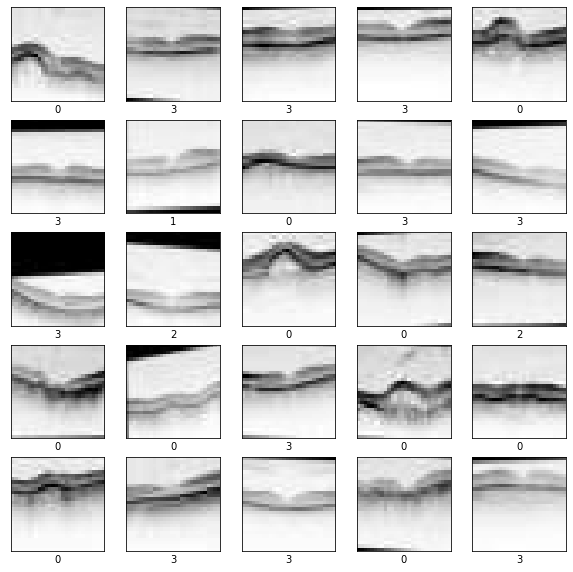

In [43]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(train_labels[i])
plt.show()

Before moving on, and this is going to be touch on on the *Training the Model* section, I want to explain why three different sets of images:

*   Training Images
*   Validation Images
*   Test Images

**Training images** are the images the neural network (also know as model) are going to use to actually *train*. If you notices this is the largest set.

**Valiadation images** have a purpose a little different. This set is not use to *train* the model. This set is to see how the model is doing. In other words is to check on the model to see how his training is going. This set is not feed for trainig is just to see trends that can sometimes lead to things like overfitting. Overfitting is when the model got really good at predicting the images in the training set but bad a other new images. This set is larger than the test set but not larger than the training set.

**Test images** this test images are similar to the ones for validation in the sense that the model does not learn from it. This set is a totally new set in which the program can make predictions. A set it has never seen before. It is common to this set to be the smaller one.

# Preprocess the data

The data must be tweeked before feeding it to the neural network.

### Range of the pixel values

When inspecting images in the training set, it is possible to found the **range** where the **pixel values fall in**. <br><br>
To do this I'm going to use `numpy.unique()` this will return the **number of times each unique value comes up** in the input array passed which in this particular ocassion is going to be all the images. The **values** that comes up are going to **represent** the values for **each pixel** in the image.<br><br>
As shown below the pixel values fall in the range of 0 to 255:





In [44]:
print(min(np.unique(train_images)))
print(max(np.unique(train_images)))

0
255


In [45]:
print(min(np.unique(validation_images)))
print(max(np.unique(validation_images)))

0
255


In [46]:
print(min(np.unique(test_images)))
print(max(np.unique(test_images)))

0
255


**Before feeding** the values to the neural network model first we need to **scale them to a range from 0 to 1**. This same preprocessed needs to be the same way for the training, validation and test set.<br><br>
The way I'm going to scale the values from 0 to 1 is by dividing every single pixel value by 255 which is the maximun value a pixel takes in any set.

In [47]:
train_images = train_images / 255.0

validation_images = validation_images / 255.0

test_images = test_images / 255.0

### Reformatting validation data to a list of tuples

When passing the **validation data** to `model.fit` **Keras is going to expect a tuple of numpy arrays or tensors.** The tuple will contain the array of the images and the array of the labels. <br><br>
For this purpose I'm going to use a method for nesting tuples but instead of putting two tuples inside a bigger tuple I'm going to put inside the tuple the two numpy arrays.

In [48]:
validation_set = (validation_images, validation_labels)

# Build the neural network

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of neural network is a layer. Most of deep learning consist of chainning together simple layers.

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4)
  ])

The **first layer** in this model, `tf.keras.layers.Flatten`, just **reformat** everything from a two dimentional array (of 28 by 28 pixels) to a one dimentional array (of 28 * 28 = 784 pixels). 

In simpler words it does not learn any parameters, just change its structure.<br><br>
The **second layer** in the model, `tf.keras.layers.Dense`, has 256 nodes (or neurons) and the activation function 'relu'.<br><br>
The **third layer** in the model, `tf.keras.layers.Droupout` is use to have a more complex neural network were the some of the neurons will be omitted, randomly. 
<br><br>
The **fourth layer** in the model is also a `tf.keras.layers.Dense` layer. This one has 4 nodes better know as logits. This 4 logits represent the categories of the images.

### Compile the model

Before the model is ready for training, it needs a few more settings.

In [50]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

The `model.compile` just gets everything ready before we can train the model.


*   **Optimizer** - This is use by the model to find the minimum of the loss function. 
*   **Loss function** - This measure how accurate the model is during training. The optimizer helps minimize this function to "point" the model in the right direction. The lower the output of this function the better for the model.
*   **Metrics** - Is use to monitor the training of the model. By using *accuracy* we get the fraction of images that are correctly classified.



# Train the model

Training the neural network model requires the following steps:

1. **Feed the training and validation data to the model** by *fitting* it to the model. In this example, the *training* data is in the `train_images` and `train_labels` arrays and the *validation* data is in the `validation_images` and `validation_labels` arrays.
2. The model **learns** from the **training data** to associate images and labels.
3. The model **compares** what it has learn in a **new data set** never seen before, the **valdiation set**. This set is going to give an overview of the model's performance. This information is used to tweak the model if needed.
4. You ask the model to **make predictions** about a ***test* set**—in this example, the `test_images` array. Given an image, the model does its best to predict the right label.
5. **Check** how well the **predictions** match the labels from the `test_labels` array.

### Fit the model to the data

In [51]:
history = model.fit(train_images, 
                    train_labels, 
                    validation_data = validation_set, 
                    epochs = 30, 
                    verbose = 2,)

Epoch 1/30
3047/3047 - 9s - loss: 0.9785 - accuracy: 0.6169 - val_loss: 0.8854 - val_accuracy: 0.6636
Epoch 2/30
3047/3047 - 8s - loss: 0.8553 - accuracy: 0.6799 - val_loss: 0.7682 - val_accuracy: 0.7196
Epoch 3/30
3047/3047 - 8s - loss: 0.7887 - accuracy: 0.7099 - val_loss: 0.7469 - val_accuracy: 0.7264
Epoch 4/30
3047/3047 - 8s - loss: 0.7421 - accuracy: 0.7292 - val_loss: 0.6809 - val_accuracy: 0.7541
Epoch 5/30
3047/3047 - 9s - loss: 0.7136 - accuracy: 0.7406 - val_loss: 0.6453 - val_accuracy: 0.7732
Epoch 6/30
3047/3047 - 8s - loss: 0.6949 - accuracy: 0.7478 - val_loss: 0.6174 - val_accuracy: 0.7808
Epoch 7/30
3047/3047 - 8s - loss: 0.6795 - accuracy: 0.7551 - val_loss: 0.6435 - val_accuracy: 0.7693
Epoch 8/30
3047/3047 - 8s - loss: 0.6682 - accuracy: 0.7609 - val_loss: 0.6165 - val_accuracy: 0.7786
Epoch 9/30
3047/3047 - 8s - loss: 0.6549 - accuracy: 0.7653 - val_loss: 0.6156 - val_accuracy: 0.7774
Epoch 10/30
3047/3047 - 8s - loss: 0.6484 - accuracy: 0.7676 - val_loss: 0.6013 - 

### Evaluate the accuracy

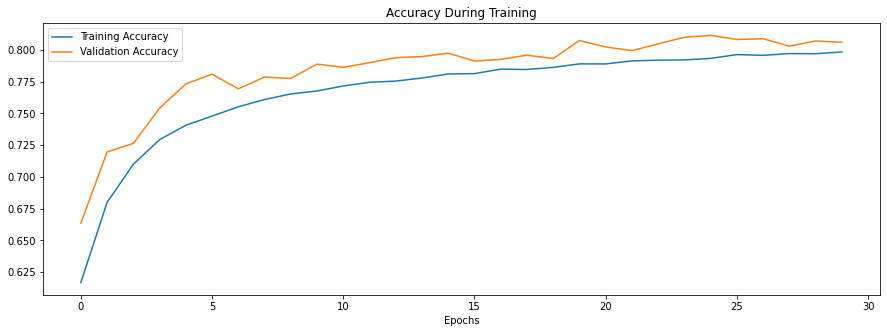

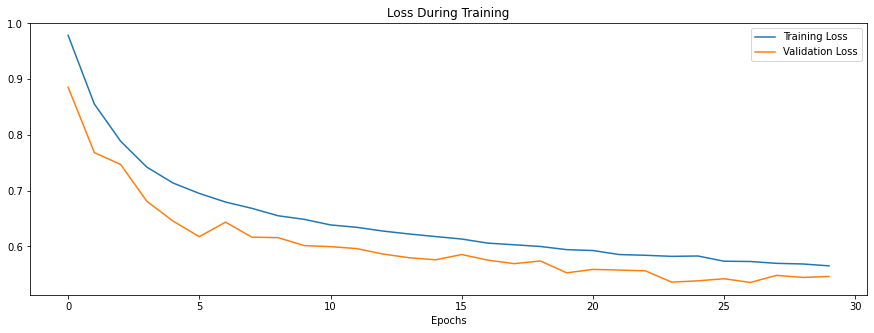

In [52]:
# How did our accuracy and loss change over time? Let's find out. 


plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.title('Accuracy During Training')

plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss']) 
plt.xlabel('Epochs')
plt.title('Loss During Training')
plt.show()

In [53]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

32/32 - 0s - loss: 1.1343 - accuracy: 0.5610

Test accuracy: 0.5609999895095825


### Make predictions

Again, thanks to not finding the representation of the numbers in the labels I wouldn't be able to show a full prediction including the names. 

Instead, what I can do is show how well the neural network did by ploting the images and what the model predicted it was.



---
<br>

The highest value on the logits, the neurons on the last layer, correspond to the prediction from the model. If we think about it we can make our model more interpretable by converting the logit outputs to probabilities, which can tell us how confident our model is. 

To accomplish this conversion of logits to a probabilities we can add on a `softmax layer`.


In [54]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

Here we are giving the set of images it is going to predict.

In [55]:
predictions = probability_model.predict(test_images)

Here is possible to see final values of the logits for the test images 

In [56]:
predictions[3]

array([0.00938304, 0.00679937, 0.04488629, 0.9389312 ], dtype=float32)

In [57]:
np.argmax(predictions[3])

3

Here we can compare see what was the actual category for the prediction from before.

In [58]:
test_labels[3]

3

This next two functions are going to help plotting some examples images, their predictions and actual values.

In [59]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel(f"{100*np.max(predictions_array):2.0f}%", color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(4))
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

###Verify predictions on unseen test images

Let's plot one image, the model prediction and also the true value. In this example we will using the first image (i = 0).

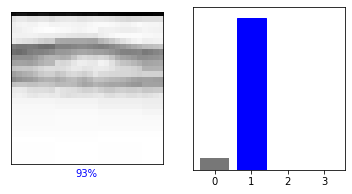

In [60]:
i = 20
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Now let's plot a total of 18 images, the first 18, and have an intuitive representation of how the program does.

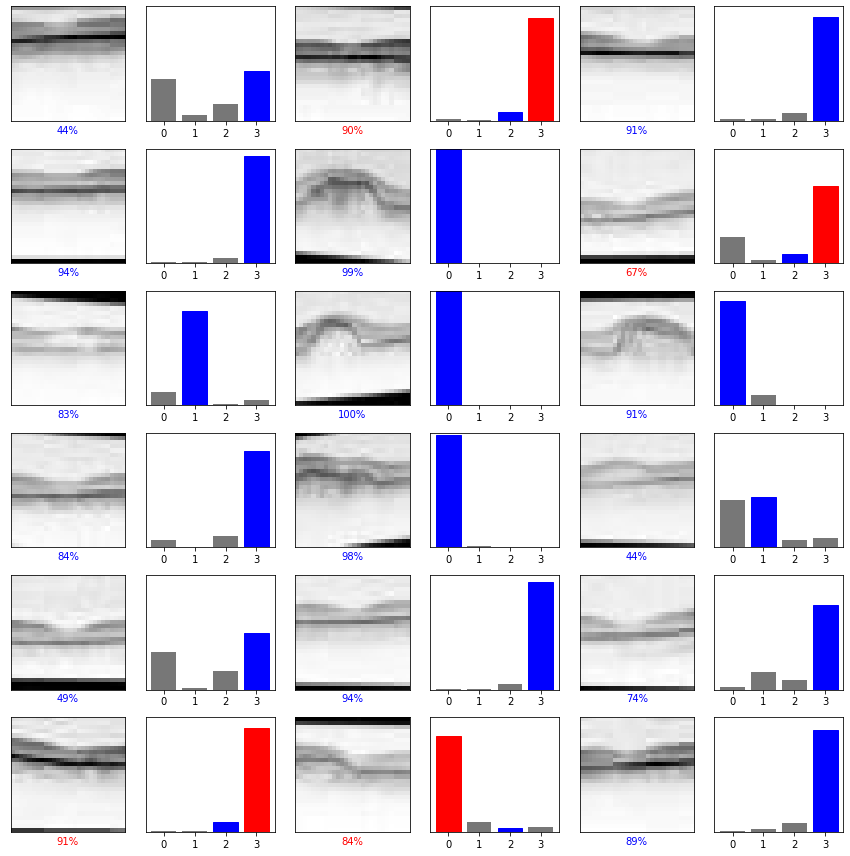

In [61]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 6
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

# Use the trained model

At last, use the trained model to make a prediction on a single test image.<br><br>

First thing to do is to grap an image from the dataset.

In [82]:
img = test_images[35]

print(img.shape)

(28, 28)


Because `tf.keras` models are optimized to make predictions on a *batch*, which is basically a collection, of examples at once. We need to make a list out of this single image.

In [83]:
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Not we proceed to predict the correct label for this image:

In [84]:
predictions_single_img = probability_model.predict(img)

print(predictions_single_img)

[[0.533232   0.01413904 0.07401106 0.37861803]]


To see which label the model predicted we can use `np.argmax`.

In [85]:
np.argmax(predictions_single_img)

0

Now to have this plot and have a better visual representation:

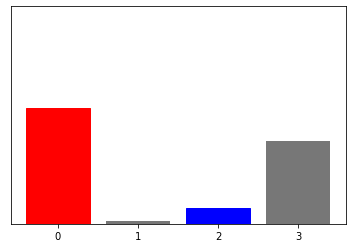

In [86]:
plot_value_array(1, predictions_single_img[0], test_labels)
graph = plt.xticks(range(4))